In [ ]:
import sys

import spatialdata as sd

sys.path.append("../../src")
import pandas as pd

from pathlib import Path

/home/icb/francesca.drummer/.local/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [ ]:
sys.path.insert(0, "../../")  # this depends on the notebook depth and must be adapted per notebook

from _paths import PROJECT_DIR, RESULTS_DIR, xenium_path_cropped
compressed_transcript_csv = Path(RESULTS_DIR, 'sainsc', 'trans.csv.gz')

In [ ]:
sdata = sd.read_zarr(xenium_path_cropped)

In [ ]:
transcripts = sdata.points["transcripts"][["feature_name", "x", "y", "codeword_category"]].compute()
transcripts = transcripts.reset_index(drop=True)

In [ ]:
transcripts = transcripts.rename({"feature_name": "gene", "x": "x", "y": "y"})
transcripts = transcripts[transcripts["codeword_category"] == "predesigned_gene"]

In [ ]:
transcripts.columns = ["gene", "x", "y", "codeword_category"]

In [ ]:
transcripts.to_csv(compressed_transcript_csv, compression="gzip")

In [15]:
import polars as pl

xenium_file = compressed_transcript_csv
n_threads = 16

# Read xenium file, rename columns and filter blanks/controls
transcripts = pl.read_csv(
    xenium_file,
    columns=["gene", "x", "y"],
    schema_overrides={"gene": pl.Categorical},
    n_threads=n_threads,
).filter(~pl.col("gene").cast(pl.Utf8).str.contains("(BLANK|NegControl)"))

In [24]:
from sainsc import LazyKDE

embryo = LazyKDE.from_dataframe(transcripts, resolution=1000, binsize=3, n_threads=n_threads)

In [25]:
embryo.calculate_total_mRNA()

In [28]:
embryo.counts.filter_genes_by_count(1)

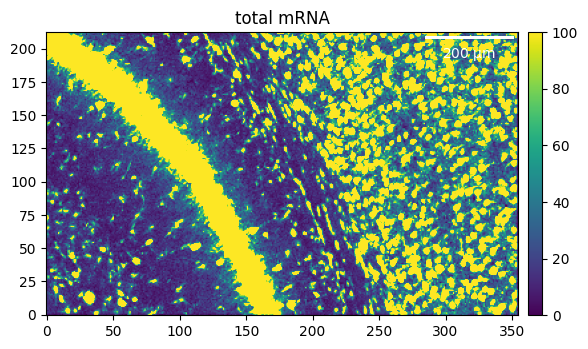

In [29]:
embryo.calculate_total_mRNA()

_ = embryo.plot_genecount(im_kwargs={"vmax": 100})

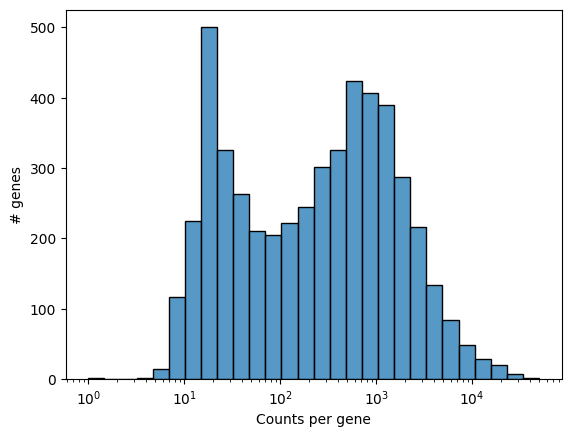

In [30]:
_ = embryo.plot_genecount_histogram()

In [31]:
embryo.gaussian_kernel(2, unit="um")

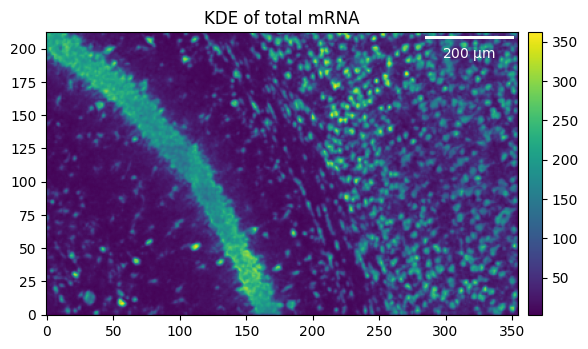

In [32]:
embryo.calculate_total_mRNA_KDE()

_ = embryo.plot_KDE()

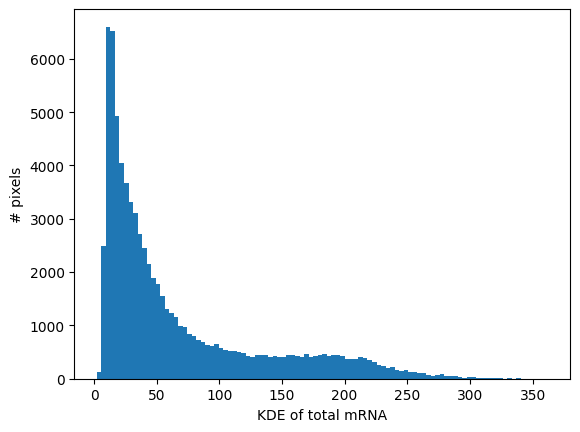

In [33]:
_ = embryo.plot_KDE_histogram(bins=100)

In [34]:
embryo.filter_background(0.4)

In [35]:
adata = sdata["table"]

In [37]:
adata

AnnData object with n_obs × n_vars = 1703 × 4226
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'dendrogram_leiden', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatialdata_attrs', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

In [38]:
expr = adata.to_df()
expr["cell_type"] = adata.obs["cell_type"]

In [39]:
signatures = expr.groupby("cell_type").mean().transpose()

In [41]:
signatures

cell_type     Astro        CA  Endothelial  Excitatory  Inhibitory    L4 EXC  \
A2m        0.013889  0.005807     0.024859    0.003144    0.004805  0.000000   
Aatf       0.079675  0.091008     0.044571    0.078290    0.086707  0.121744   
Abca1      0.383595  0.053215     0.152661    0.019763    0.085482  0.021830   
Abca3      0.221554  0.276906     0.249474    0.394378    0.422939  0.372388   
Abca4      0.010897  0.001494     0.008366    0.005956    0.004350  0.000000   
...             ...       ...          ...         ...         ...       ...   
Zswim5     0.021280  0.114681     0.007139    0.045506    0.068085  0.013933   
Zswim9     0.040617  0.030781     0.000000    0.030981    0.039470  0.018225   
Zup1       0.033266  0.010388     0.028482    0.012506    0.017670  0.012902   
Zyx        0.042699  0.017491     0.061100    0.092842    0.090022  0.078873   
Zzef1      0.128386  0.165635     0.126091    0.196425    0.164290  0.237142   

cell_type  Microglia       OPC     Oligo  Pericyte  
A2m         0.011265  0.000000  0.005264  0.000000  
Aatf        0.132461  0.154984  0.104333  0.077079  
Abca1       0.635897  0.448588  0.177629  0.075678  
Abca3       0.124057  0.291397  0.221988  0.139689  
Abca4       0.014046  0.000000  0.000000  0.068166  
...              ...       ...       ...       ...  
Zswim5      0.075618  0.081543  0.035224  0.000000  
Zswim9      0.000000  0.027234  0.027637  0.028339  
Zup1        0.057853  0.026454  0.020676  0.000000  
Zyx         0.047341  0.086621  0.152378  0.033775  
Zzef1       0.114488  0.193400  0.199655  0.071949  

[4226 rows x 10 columns]

In [ ]:
# this for all cells
###expr=adata.to_df()
#####signatures=expr.transpose()

In [40]:
embryo.assign_celltype(signatures, log=True)

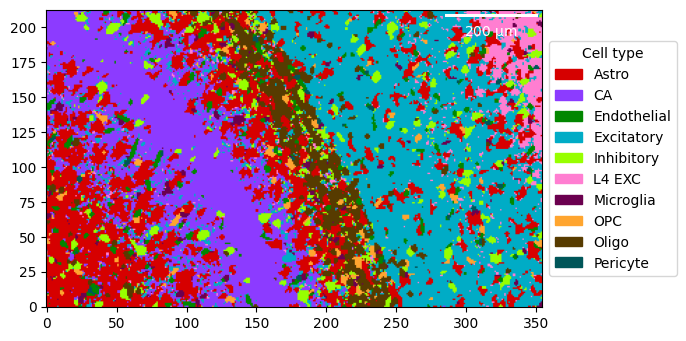

In [42]:
import colorcet as cc
import seaborn as sns

cmap = dict(zip(embryo.celltypes, sns.color_palette(cc.glasbey, n_colors=len(embryo.celltypes)), strict=False))

_ = embryo.plot_celltype_map(cmap=cmap)

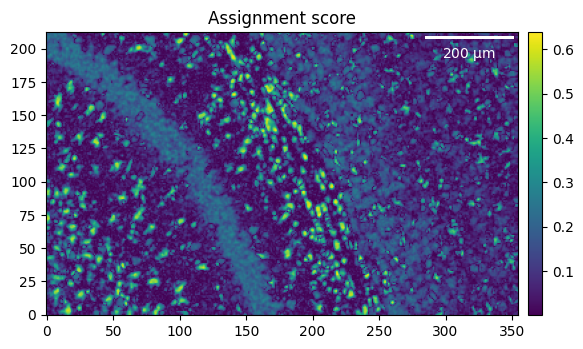

In [43]:
_ = embryo.plot_assignment_score()

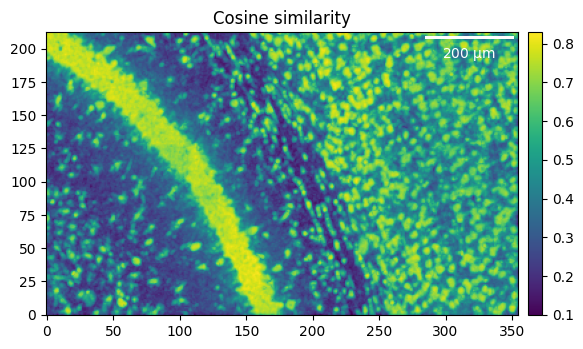

In [44]:
_ = embryo.plot_cosine_similarity()

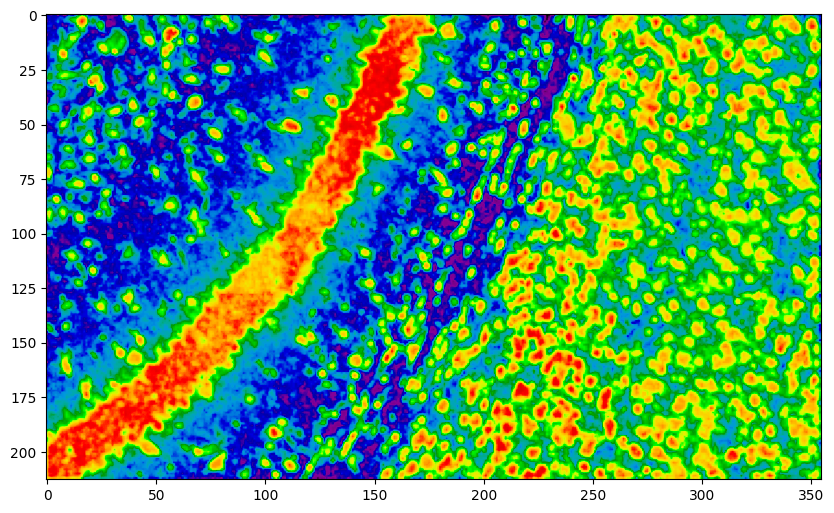

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(embryo.cosine_similarity.transpose(), cmap="nipy_spectral", vmax=0.9)

In [49]:
celltype = embryo.celltype_map.flatten()
assignment_score = embryo.assignment_score.flatten()
cosine_similarity = embryo.cosine_similarity.flatten()
output_df = pd.DataFrame({"cell type": celltype, "assignment_score": assignment_score, "cosine_similarity": cosine_similarity})
num2ct = dict(zip(range(0, len(embryo.celltypes)), embryo.celltypes, strict=False))
output_df["cell type"] = output_df["cell type"].map(num2ct)

In [54]:
filt = list((output_df["cell type"] == "Astro") & (output_df["cosine_similarity"] > 0.5))

In [55]:
import numpy as np
from tqdm import tqdm

allres = np.zeros([np.sum(filt), len(embryo.counts.genes())])
n = 0
for g in tqdm(embryo.counts.genes()):
    allres[:, n] = embryo.counts.get(g).todense().flatten()[filt]
    n = n + 1

100%|██████████| 5005/5005 [00:19<00:00, 258.16it/s]


In [226]:
import scanpy as sc

adata = sc.AnnData(allres)
adata.var.index = embryo.counts.genes()

In [227]:
x_coords, y_coords = np.meshgrid(np.arange(embryo.celltype_map.shape[1]), np.arange(embryo.celltype_map.shape[0]))

In [228]:
adata.obs["x"] = x_coords.flatten()[filt]
adata.obs["y"] = y_coords.flatten()[filt]

In [229]:
adata.obs["cosine_similarity"] = output_df["cosine_similarity"][filt]

In [230]:
adata.obsm["spatial"] = np.array(adata.obs.loc[:, ["y", "x"]])

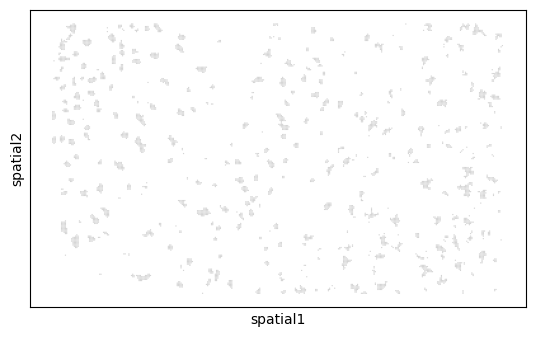

In [233]:
sc.pl.spatial(adata, spot_size=1)

In [234]:
adata

AnnData object with n_obs × n_vars = 4411 × 5006
    obs: 'x', 'y', 'cosine_similarity'
    obsm: 'spatial'

In [235]:
adata.obs["total_counts"] = np.sum(adata.X, axis=1)

In [236]:
sc.pp.filter_cells(adata, min_counts=5)

In [237]:
sc.pp.filter_cells(adata, min_genes=3)

In [238]:
adata

AnnData object with n_obs × n_vars = 4408 × 5006
    obs: 'x', 'y', 'cosine_similarity', 'total_counts', 'n_counts', 'n_genes'
    obsm: 'spatial'

(array([248., 715., 938., 759., 461., 353., 227., 180., 160.,  81.,  85.,
         75.,  41.,  33.,  23.,  11.,  11.,   4.,   2.,   1.]),
 array([  5.  ,  20.85,  36.7 ,  52.55,  68.4 ,  84.25, 100.1 , 115.95,
        131.8 , 147.65, 163.5 , 179.35, 195.2 , 211.05, 226.9 , 242.75,
        258.6 , 274.45, 290.3 , 306.15, 322.  ]),
 <BarContainer object of 20 artists>)

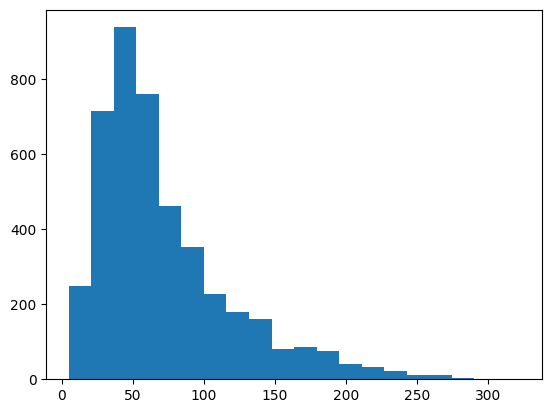

In [239]:
plt.hist(adata.obs["n_counts"], bins=20)

In [240]:
adata.layers["raw"] = adata.X

In [241]:
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)

In [257]:
adata

AnnData object with n_obs × n_vars = 4408 × 5006
    obs: 'x', 'y', 'cosine_similarity', 'total_counts', 'n_counts', 'n_genes', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'distances', 'connectivities'

In [255]:
seed = 42
sc.pp.pca(adata)

In [258]:
sc.pp.neighbors(adata, random_state=seed, n_pcs=0, n_neighbors=10)

In [264]:
sc.tl.umap(adata, min_dist=0.03, random_state=seed)

In [266]:
sc.tl.leiden(adata, resolution=0.7, random_state=seed)

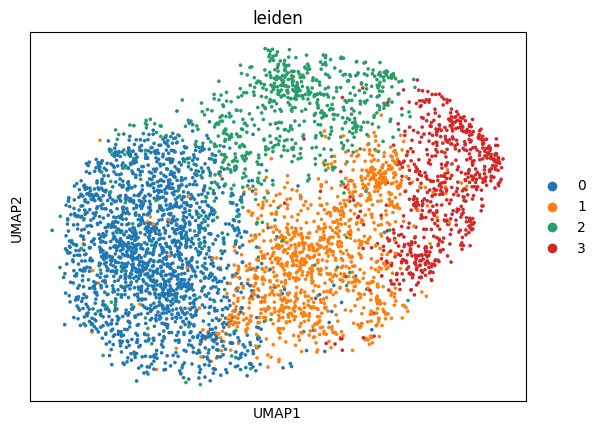

In [267]:
sc.pl.umap(adata, color="leiden")

In [273]:
adata.obs.to_csv("/media/sergio/Discovair_final/leiden_clust.csv")

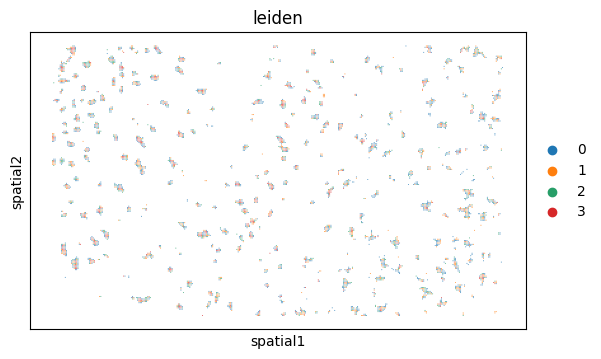

In [272]:
sc.pl.spatial(adata, spot_size=0.7, color="leiden")

In [ ]:
# Plot per cell type

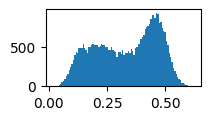

10


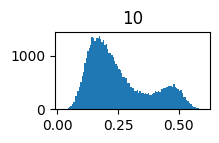

11


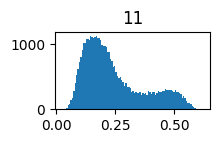

12


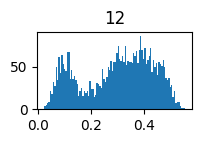

3


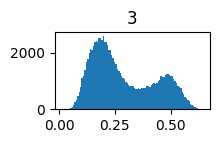

4


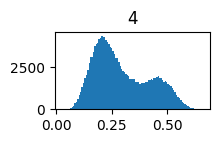

5


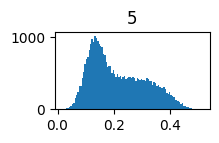

7


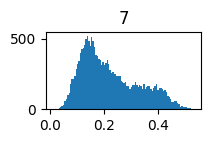

9


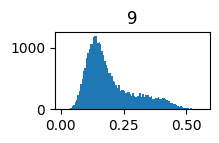

Astro


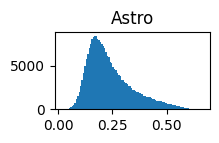

CA


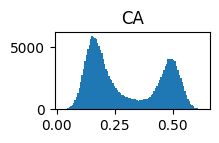

INH


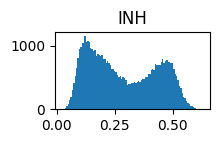

Oligo


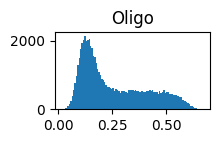

In [48]:
import matplotlib.pyplot as plt

for n, g in output_df.groupby("cell type"):
    print(n)
    plt.figure(figsize=(2, 1))
    ss = plt.hist(g["cosine_similarity"], bins=100)
    plt.title(n)
    plt.show()

In [103]:
# de novo signature identification

In [105]:
embryo.find_local_maxima(4, min_area=60)
print(embryo)

cellproxy_adata = embryo.load_local_maxima(embryo.genes)
print(cellproxy_adata)

LazyKDE (16 threads)
    genes: 5006
    shape: (1329, 798)
    resolution: 800.0 nm / px
    kernel: (11, 11)
    background: set
    local maxima: 2708
    celltypes: 13
AnnData object with n_obs × n_vars = 2708 × 5006
    obs: 'total_mRNA_KDE', 'cosine_similarity', 'assignment_score', 'celltype'
    obsm: 'spatial'


/home/sergio/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [106]:
import scanpy as sc

# remove potential genes w/o counts
cellproxy_adata = cellproxy_adata[:, cellproxy_adata.X.sum(axis=0).A1 > 0].copy()

# "normalize" data
sc.pp.normalize_total(cellproxy_adata)
sc.pp.log1p(cellproxy_adata)

/home/sergio/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/sergio/.local/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 5003 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1052381/1407398117.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(cellproxy_adata, resolution=1.5, random_state=seed)


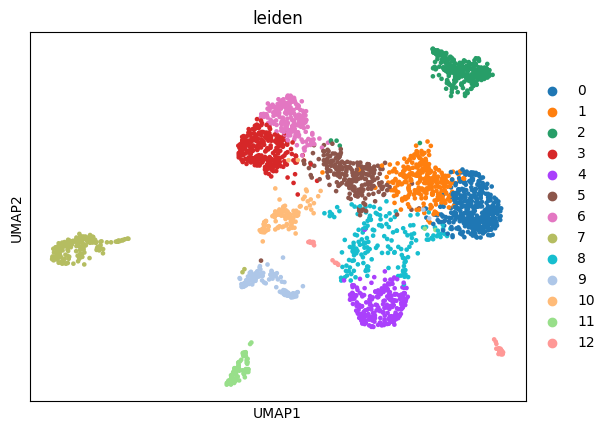

In [ ]:
seed = 42
sc.pp.neighbors(cellproxy_adata, random_state=seed)
sc.tl.umap(cellproxy_adata, min_dist=0.1, random_state=seed)
sc.tl.leiden(cellproxy_adata, resolution=1.5, random_state=seed)
sc.pl.umap(cellproxy_adata, color="leiden")

In [113]:
from sainsc.utils import celltype_signatures

signatures_denovo = celltype_signatures(cellproxy_adata, celltype_col="leiden")
embryo.assign_celltype(signatures_denovo, log=True)

: 

In [ ]:
cmap_denovo = dict(
    zip(
        cellproxy_adata.obs["leiden"].cat.categories,
        cellproxy_adata.uns["leiden_colors"],
        strict=False,
    )
)

_ = embryo.plot_celltype_map(cmap=cmap_denovo)

In [4]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr). Please see the
         documentation of `is_self_contained()` to understand the implications of working with SpatialData objects 
         that are not self-contained.                                                                              
INFO     The Zarr backing store has been changed from /media/sergio/Discovair_final/mousebrain_prime_crop.zarr the 
         new file path: /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr                    


/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/sergio/anaconda3/envs/spatial_exrna/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing th

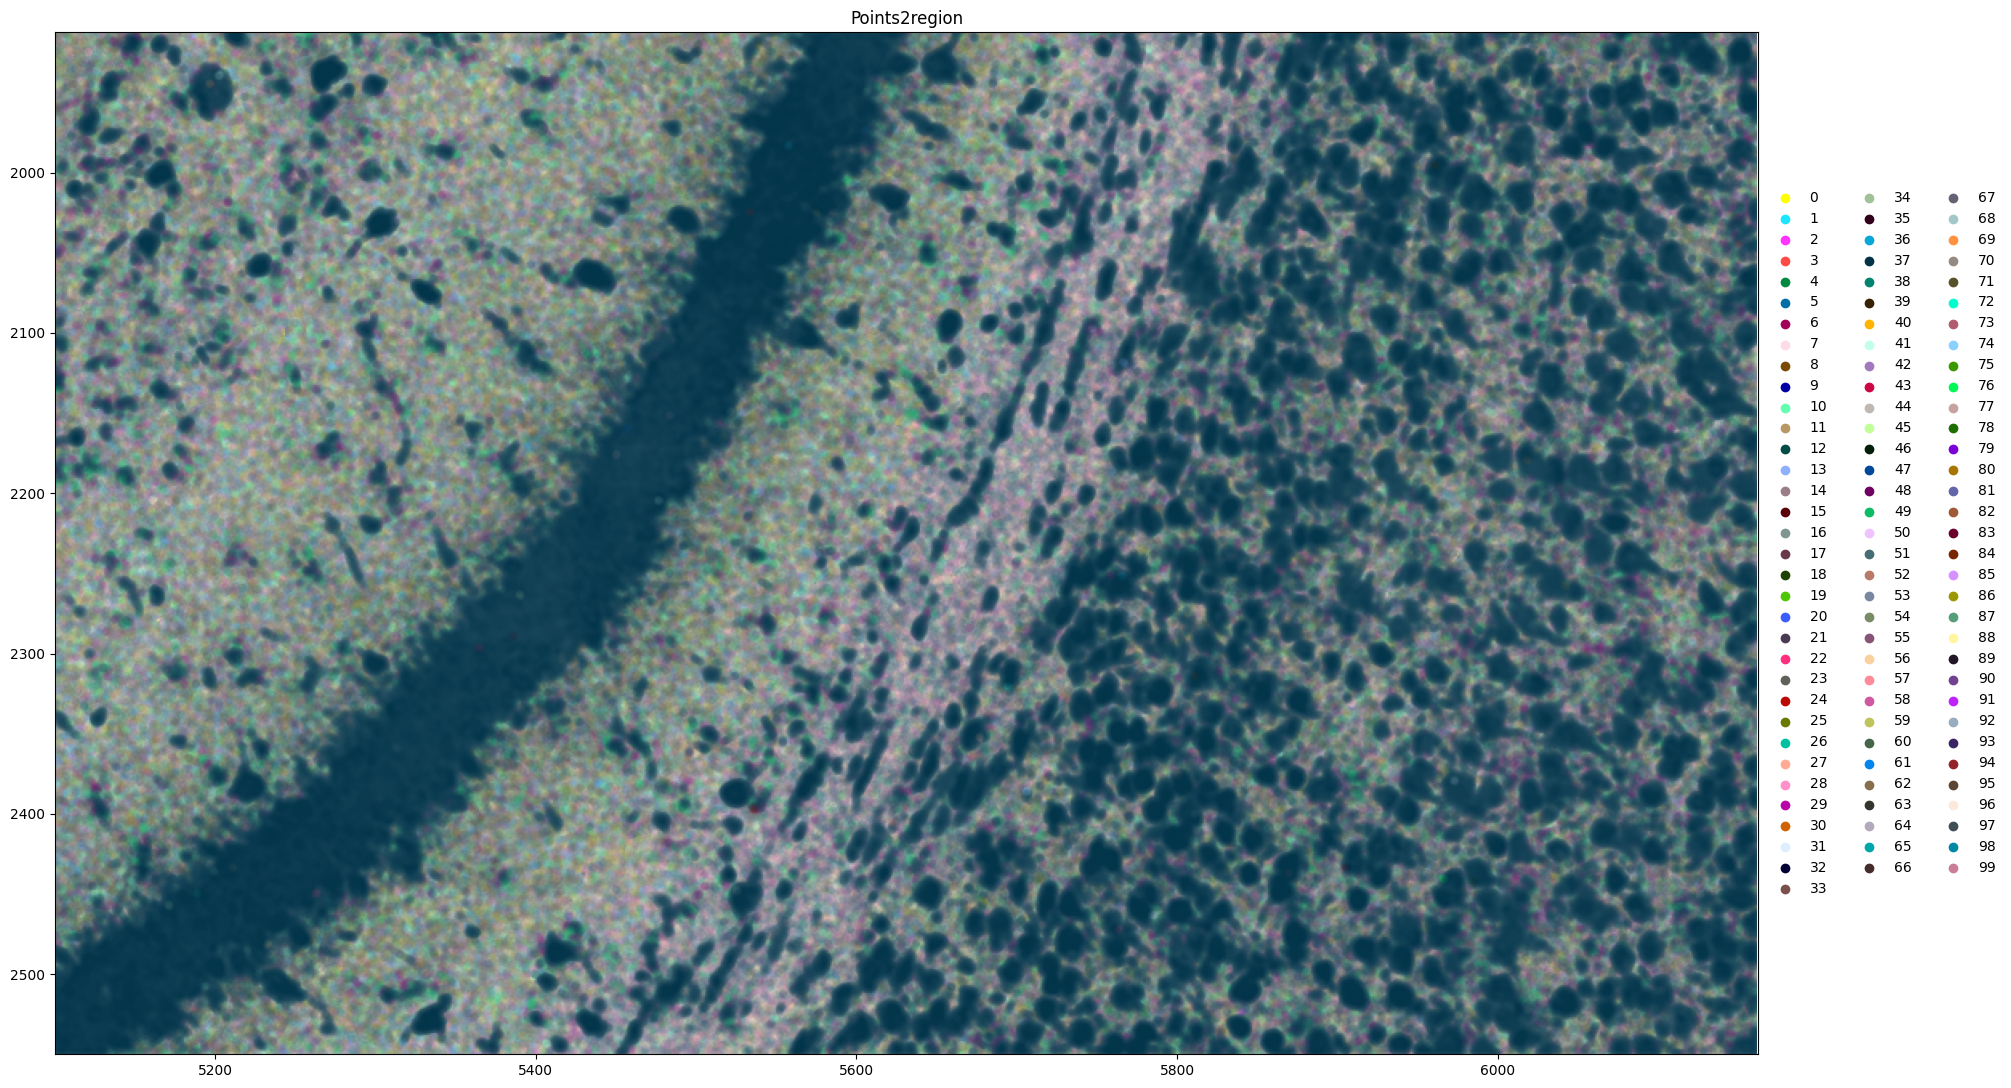

In [5]:
sdata.pl.render_points("transcripts", color="points2region", size=5.0).pl.show(title="Points2region", coordinate_systems="global", figsize=(20, 20))